1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

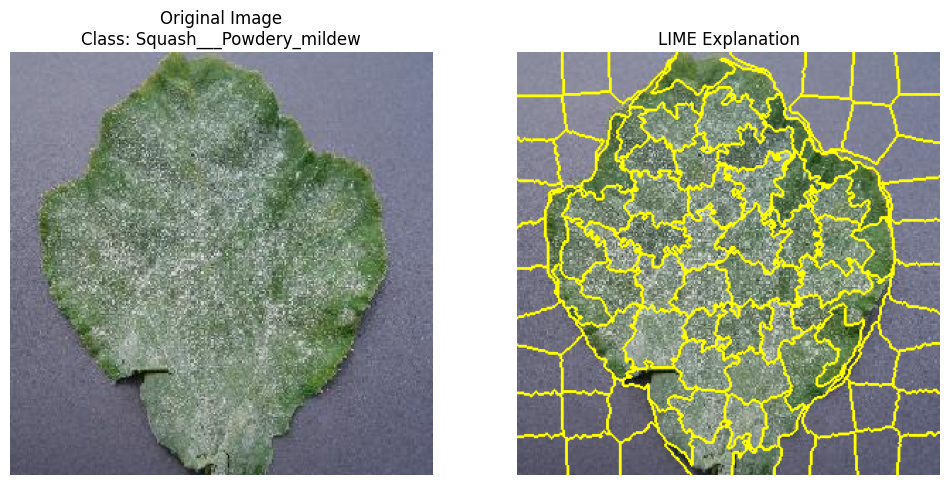

Predicted Class: Squash___Powdery_mildew
Recommended Treatment: Apply a fungicide like Sulfur or Potassium bicarbonate. Ensure thorough coverage of all leaves and stems. Repeat applications every 7-10 days, especially during humid weather. Improve air circulation by spacing plants properly. Avoid overhead watering to reduce leaf wetness. Monitor the plants regularly and reapply fungicide as needed.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries

# Load the trained model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5", compile=False)

# Load treatment data from Excel
treatment_df = pd.read_excel(r"C:\Users\USER\Desktop\plant_disease_treatments.xlsx", sheet_name="plant_disease_treatments(data)")

# Image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299

# Function to get class names
def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    return {idx: class_name for idx, class_name in enumerate(classes)}

train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"
class_names = get_class_names_from_directory(train_data_folder)

# Preprocess image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

# LIME XAI with segmentation
def explain_with_lime(image_path, model):
    def preprocess_for_lime(img):
        return np.expand_dims(img / 255.0, axis=0)
    
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img) / 255.0
    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_array, model.predict, top_labels=1, hide_color=0, num_samples=1000)
    
    segments = slic(img_array, n_segments=100, compactness=10, sigma=1)
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    lime_result = mark_boundaries(temp, segments, color=(1, 1, 0))  # Yellow boundaries
    
    return lime_result

# Get treatment recommendation
def get_treatment_recommendation(disease):
    treatment_row = treatment_df[treatment_df['Disease'] == disease]
    if not treatment_row.empty:
        return treatment_row.iloc[0]['Treatment']
    else:
        return "No specific treatment found."

# Predict and display results
def predict_and_display(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names.get(predicted_class, "Unknown")
    
    if "healthy" in class_name.lower():
        print(f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}")
        print("Leaf is Healthy. No disease detected.")
        return
    
    lime_explanation = explain_with_lime(image_path, model)
    treatment = get_treatment_recommendation(class_name)
    
    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title(f"Original Image\nClass: {class_name}")
    plt.axis('off')
    
    # LIME Explanation
    plt.subplot(1, 2, 2)
    plt.imshow(lime_explanation)
    plt.title("LIME Explanation")
    plt.axis('off')
    
    plt.show()
    
    print(f"Predicted Class: {class_name}")
    print(f"Recommended Treatment: {treatment}")

# Example usage
image_path = r"D:\project\25000reduced_dataset_split_dataset\test\Squash___Powdery_mildew\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG"
predict_and_display(image_path, model)


Enter test image paths separated by commas:  D:\project\25000reduced_dataset_split_dataset\test\Squash___Powdery_mildew\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

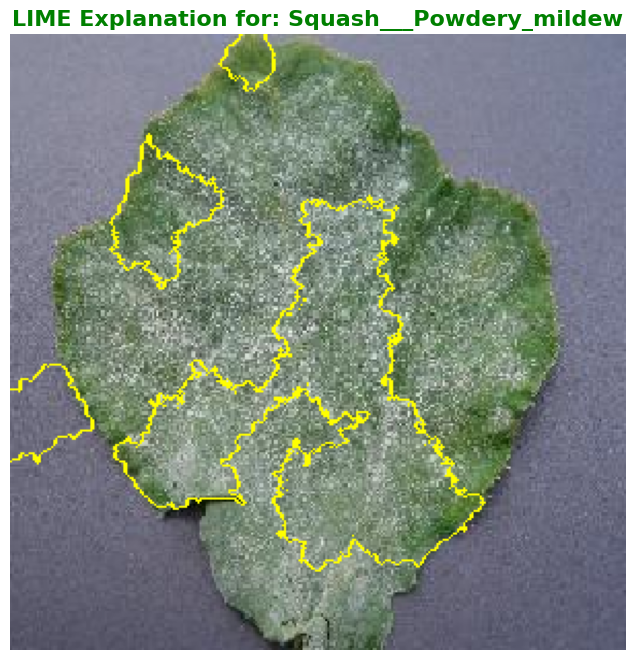

Image: 71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG --> Predicted Class: Squash___Powdery_mildew


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load the trained Inception V3 model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5")

# Define image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299  # Matches Inception V3 input size

# Automated function to get class names from the dataset directory structure
def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    class_indices = {class_name: idx for idx, class_name in enumerate(classes)}
    return {v: k for k, v in class_indices.items()}

# Path to training data folder (used for reference to extract class names)
train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"  # Replace with your training dataset path

# Automatically get class names
class_names = get_class_names_from_directory(train_data_folder)

# Function to preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Custom predict function for LIME
def lime_predict_function(img_batch):
    img_batch = img_batch.astype("float32") / 255.0  # Normalize input batch
    return model.predict(img_batch)

# Function to display predictions with LIME explanations
def predict_and_display_with_explanations(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names[predicted_class]
    
    #SLIC SEGMENTATION
    # LIME explanation
    explainer = lime_image.LimeImageExplainer()
    resized_img = cv2.resize(np.uint8(img_array[0] * 255), (IMG_WIDTH, IMG_HEIGHT))
    
    #PERTUBATION
    explanation = explainer.explain_instance(
        resized_img,
        lime_predict_function,
        top_labels=3,
        hide_color=0,
        num_samples=1000
    )
    
    # Access explanation for predicted class
    top_labels = explanation.top_labels
    if predicted_class not in top_labels:
        print(f"Predicted class {predicted_class} not in LIME's top labels. Using top label instead.")
        predicted_class = top_labels[0]

    #FEATURE EXTRACTION
    lime_image_overlay, mask = explanation.get_image_and_mask(
        label=predicted_class,
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.01
    )
    
    # Display LIME explanation
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(lime_image_overlay, mask))
    plt.title(f"LIME Explanation for: {class_name}", fontsize=16, color='green', weight='bold')
    plt.axis('off')
    plt.show()
    
    print(f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}")

# Input test image paths
test_image_paths_input = input("Enter test image paths separated by commas: ").strip()

# Split and clean paths
test_image_paths = [path.strip().strip('"') for path in test_image_paths_input.split(',')]

# Validate each path
for image_path in test_image_paths:
    if os.path.exists(image_path):
        predict_and_display_with_explanations(image_path, model)
    else:
        print(f"Error: The image path '{image_path}' does not exist. Please check the path.")


Enter a value for alpha (transparency) between 0 and 1 (e.g., 0.4):  0.5
Enter test image paths separated by commas:  D:\project\25000reduced_dataset_split_dataset\test\Squash___Powdery_mildew\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

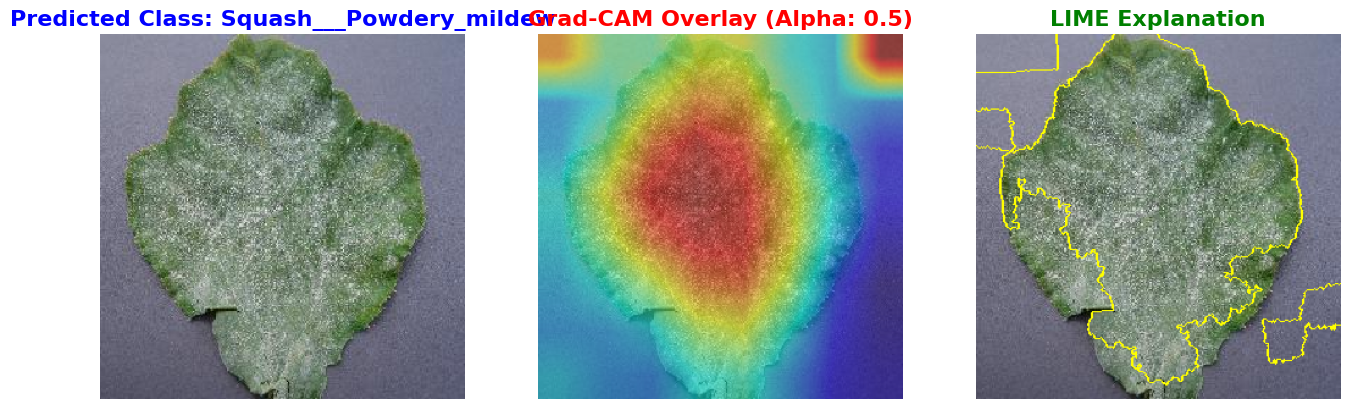

Image: 71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG --> Predicted Class: Squash___Powdery_mildew


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import cv2
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic

# Load the trained Inception V3 model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5")

# Define image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299  # Matches Inception V3 input size

# Function to get class names

def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    class_indices = {class_name: idx for idx, class_name in enumerate(classes)}
    return {v: k for k, v in class_indices.items()}

train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"
class_names = get_class_names_from_directory(train_data_folder)

# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize
    return img_array

# LIME prediction function
def lime_predict_function(img_batch):
    img_batch = img_batch.astype("float32") / 255.0  # Normalize input batch
    return model.predict(img_batch)

# Function to apply Grad-CAM
def generate_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name='mixed10'):
    grad_model = Model(inputs=model.input, 
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap_on_image(img_array, heatmap, alpha=0.4):
    img = np.uint8(img_array[0] * 255)
    heatmap = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Function to process an image and display explanations
def predict_and_display_with_explanations(image_path, model, alpha):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names.get(predicted_class, "Unknown")
    
    # Grad-CAM
    heatmap = generate_gradcam_heatmap(model, img_array, predicted_class)
    overlay_image = overlay_heatmap_on_image(img_array, heatmap, alpha)
    
    # LIME explanation
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.uint8(img_array[0] * 255),
        lime_predict_function,
        top_labels=3,
        hide_color=0,
        num_samples=1500,
        segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10)  # Custom segmentation
    )
    
    lime_image_overlay, mask = explanation.get_image_and_mask(
        label=predicted_class,
        positive_only=True,
        hide_rest=False,
        num_features=20,
        min_weight=0.002
    )
    
    # Display images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(np.uint8(img_array[0] * 255))
    plt.title(f"Predicted Class: {class_name}", fontsize=16, color='blue', weight='bold')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM Overlay (Alpha: {alpha})", fontsize=16, color='red', weight='bold')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(lime_image_overlay, mask))
    plt.title("LIME Explanation", fontsize=16, color='green', weight='bold')
    plt.axis('off')
    
    plt.show()
    print(f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}")

# Get user input
alpha_value = float(input("Enter a value for alpha (transparency) between 0 and 1 (e.g., 0.4): "))
test_image_paths_input = input("Enter test image paths separated by commas: ").strip()
test_image_paths = [path.strip().strip('"') for path in test_image_paths_input.split(',')]

# Validate and process images
for image_path in test_image_paths:
    if os.path.exists(image_path):
        predict_and_display_with_explanations(image_path, model, alpha_value)
    else:
        print(f"Error: The image path '{image_path}' does not exist. Please check the path.")


Enter test image path: C:\Users\USER\Pictures\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


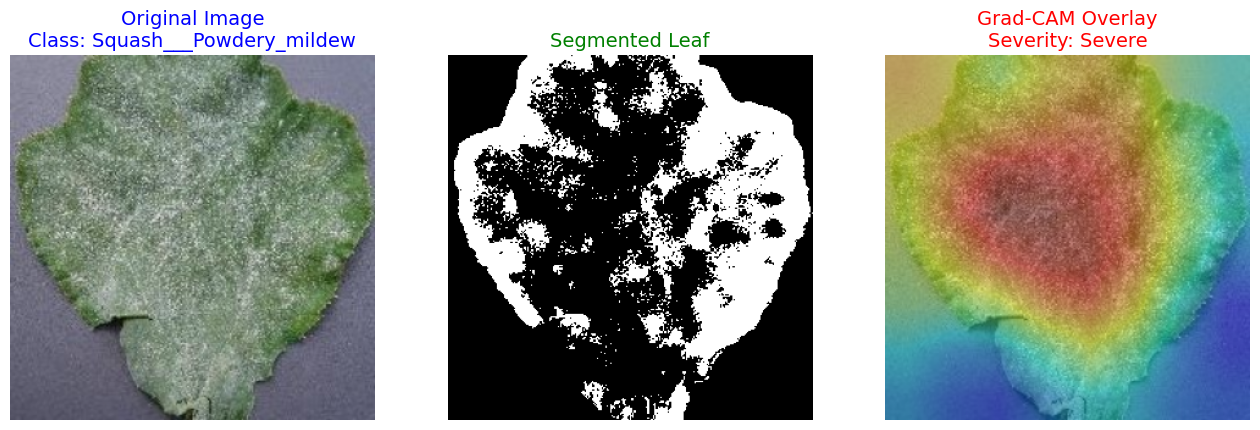

Image: 71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG --> Predicted Class: Squash___Powdery_mildew
Leaf Coverage: 27543 pixels
Heatmap Coverage: 53.91%
Severity Level: Severe


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import cv2
import os
from skimage.segmentation import slic

# Load the trained model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5", compile=False)

# Image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299

# Function to get class names from dataset directory
def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    return {idx: class_name for idx, class_name in enumerate(classes)}

train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"
class_names = get_class_names_from_directory(train_data_folder)

# Preprocess image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array
#LEAF SEGMENTATION 
# Leaf segmentation using color thresholding
def segment_leaf(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define color range for green leaf segmentation
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])
    
    mask = cv2.inRange(hsv, lower_green, upper_green)  # Binary mask
    leaf_area = np.sum(mask > 0)  # Count leaf pixels
    
    return mask, leaf_area, img  # Return mask and total leaf pixels
#HEATMAP PIXEL CALCULATED
# Generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name='mixed10'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))  # Resize to match image size
    return heatmap
#DISEASE PIXEL ANALYSIS
# Calculate severity based on heatmap vs. leaf coverage
def calculate_severity(leaf_mask, heatmap):
    heatmap_threshold = 0.6  # Set threshold to detect affected pixels
    heatmap_mask = (heatmap > heatmap_threshold).astype(np.uint8)  # Binary mask for affected areas
    
    heatmap_coverage = np.sum(heatmap_mask * (leaf_mask > 0))  # Overlap of heatmap with leaf
    leaf_coverage = np.sum(leaf_mask > 0)  # Total leaf pixels
    
    if leaf_coverage == 0:  # Avoid division by zero
        return "Unknown", 0.0

    coverage_ratio = (heatmap_coverage / leaf_coverage) * 100

    if coverage_ratio >= 50:
        severity = "Severe"
    elif 20 <= coverage_ratio < 50:
        severity = "Moderate"
    else:
        severity = "Mild"

    return severity, coverage_ratio

# Overlay heatmap on image
def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay, heatmap_colored

# Predict and display results
def predict_and_display(image_path, model, alpha=0.4):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names.get(predicted_class, "Unknown")

    # If the leaf is healthy, skip Grad-CAM and severity calculation
    if "healthy" in class_name.lower():
        print(f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}")
        print("Leaf is Healthy. No disease detected.")
        return

    # Segment leaf
    leaf_mask, leaf_area, resized_img = segment_leaf(image_path)
    
    # Generate Grad-CAM
    heatmap = generate_gradcam_heatmap(model, img_array, predicted_class)
    
    # Calculate severity
    severity, heatmap_coverage = calculate_severity(leaf_mask, heatmap)
    
    # Overlay heatmap on original image
    overlay_image, heatmap_colored = overlay_heatmap_on_image(resized_img, heatmap, alpha)
    
    # Display images
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nClass: {class_name}", fontsize=14, color='blue')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(leaf_mask, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Leaf", fontsize=14, color='green')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM Overlay\nSeverity: {severity}", fontsize=14, color='red')
    plt.axis('off')
    
    plt.show()
    
    print(f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}")
    print(f"Leaf Coverage: {leaf_area} pixels")
    print(f"Heatmap Coverage: {heatmap_coverage:.2f}%")
    print(f"Severity Level: {severity}")

# Example usage
image_path = input("Enter test image path:")
predict_and_display(image_path, model, alpha=0.4)



==== ONTOLOGY DATA INGESTION ====


C:\Users\USER\AppData\Local\Temp\ipykernel_8580\4079378973.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Data loaded and cleaned successfully.

==== SEMANTIC ENTITY EXTRACT ====


Enter the predicted plant name:  squash


Diseases affecting squash retrieved.

==== NODE CREATION & ONTOLOGY FEATURE MAPPING ====
Nodes and edges successfully added to the graph.

==== DAG STRUCTURE GENERATION ====
Graph layout computed.

==== GRAPH VISUALIZATION ====


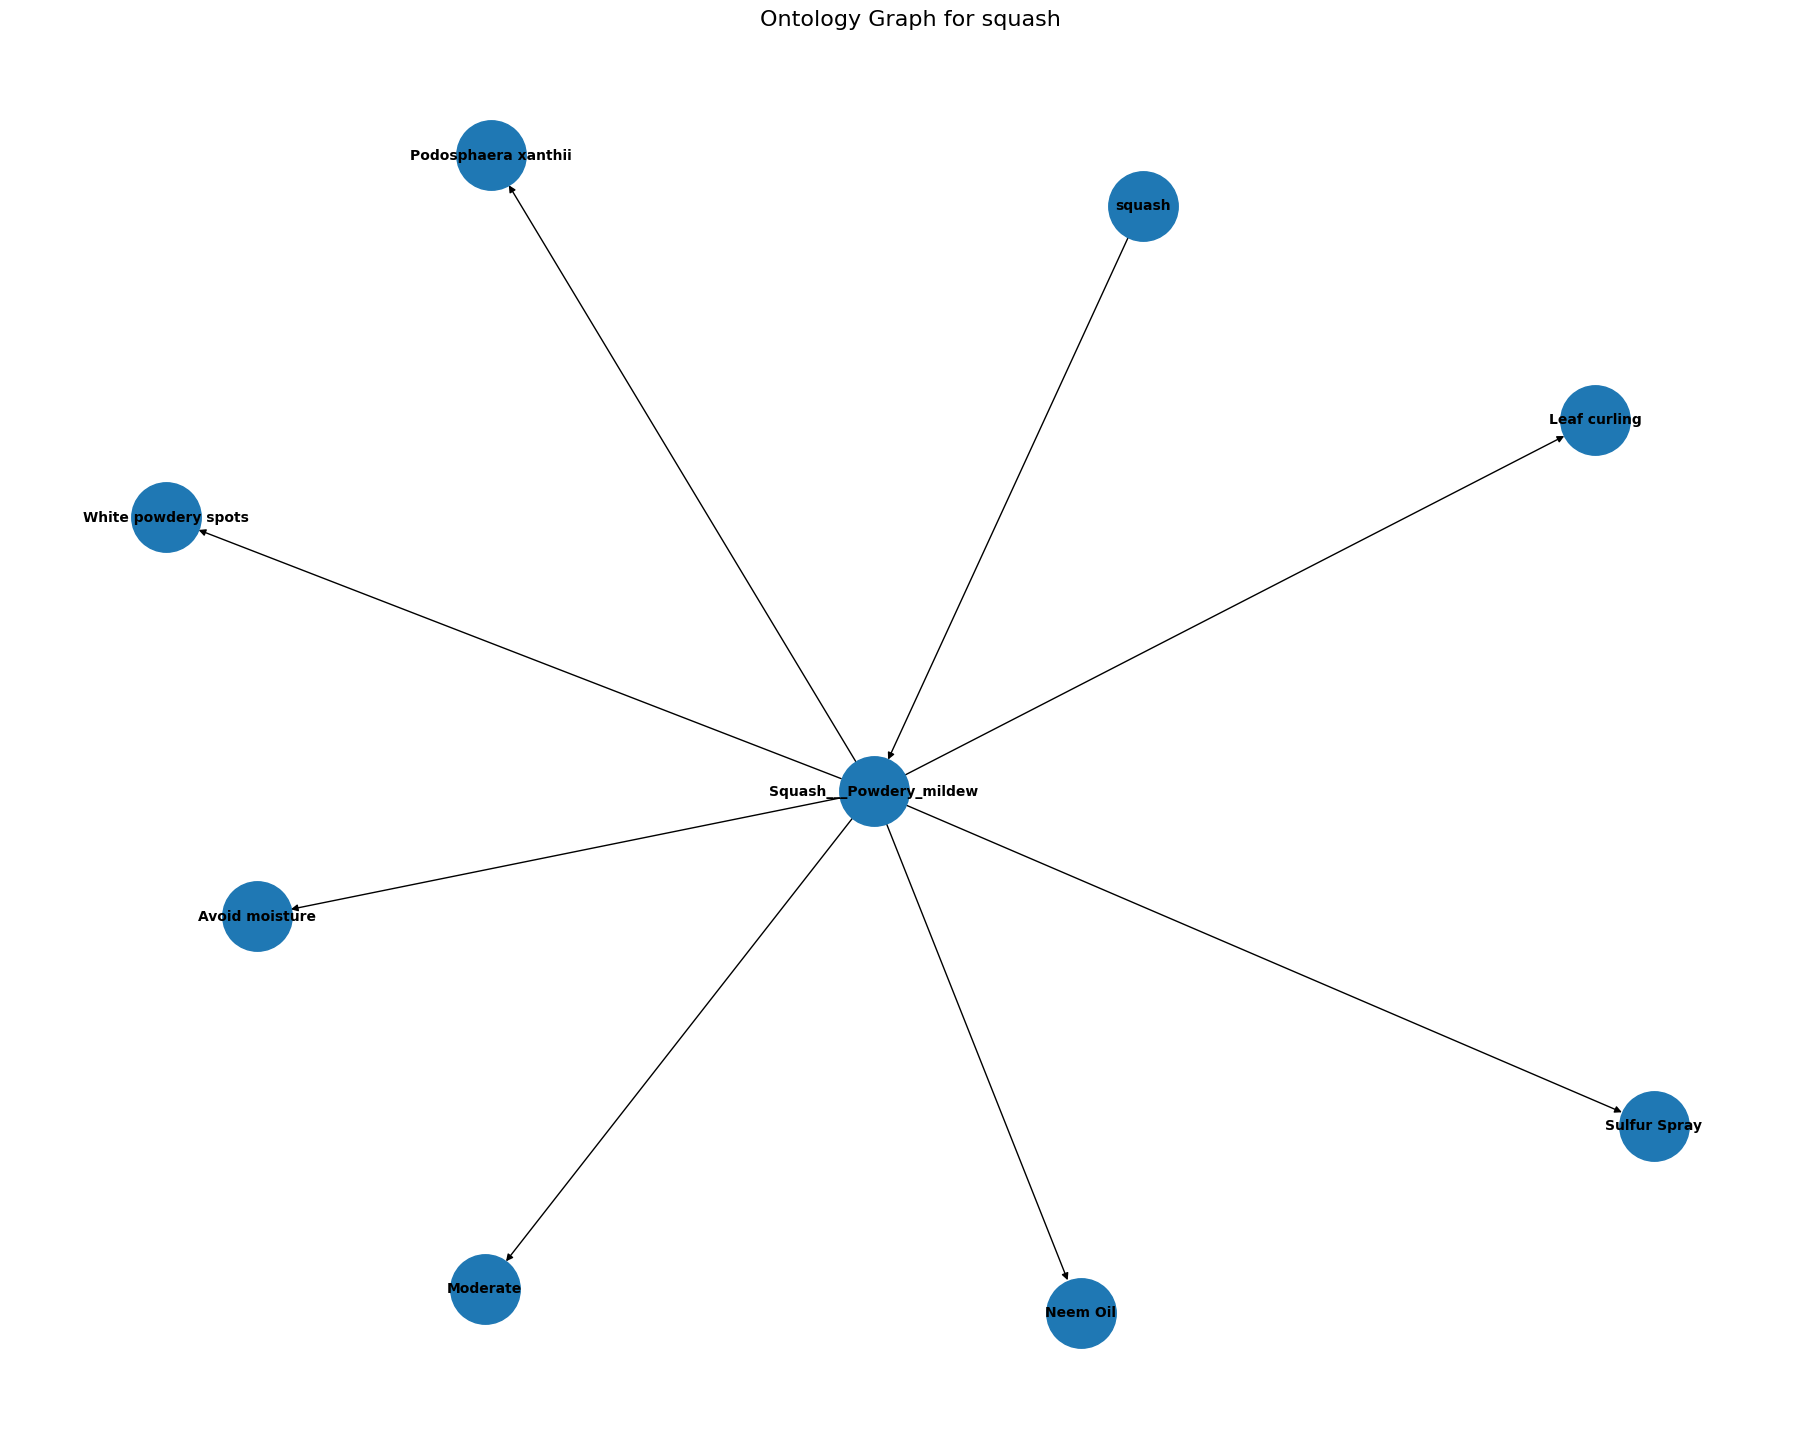

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ONTOLOGY DATA INGESTION
print("\n==== ONTOLOGY DATA INGESTION ====")
# Load dataset from CSV
df = pd.read_csv(r"C:\Users\USER\Desktop\Project2\plant_disease_ontology.csv", encoding="utf-8")

# Clean column names and remove extra spaces in string values
df.columns = df.columns.str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
print("Data loaded and cleaned successfully.")

# SEMANTIC ENTITY EXTRACT
print("\n==== SEMANTIC ENTITY EXTRACT ====")
# Get user input for the plant
predicted_plant = input("Enter the predicted plant name: ").strip()

# Filter data to get only diseases affecting the input plant
plant_df = df[df["Plant Affected"].str.lower() == predicted_plant.lower()]
print(f"Diseases affecting {predicted_plant} retrieved.")

# NODE CREATION & ONTOLOGY FEATURE MAPPING
if plant_df.empty:
    print(f"No disease data found for {predicted_plant}.")
else:
    print("\n==== NODE CREATION & ONTOLOGY FEATURE MAPPING ====")
    # Create a directed graph (DAG)
    G = nx.DiGraph()

    # Add plant node as the root node
    G.add_node(predicted_plant)

    # Iterate through each row in the filtered dataframe
    for _, row in plant_df.iterrows():
        disease = row["Disease"]  # Extract disease name
        category = row["Category"]  # Disease category
        symptom1 = row["Symptom1"]
        symptom2 = row["Symptom2"]
        remedy1 = row["Remedy1"]
        remedy2 = row["Remedy2"]
        cause = row["Cause"]
        preventive = row["Preventive Measures"]
        severity = row["Severity Level"]

        # Add disease node and link it to the plant
        G.add_node(disease)
        G.add_edge(predicted_plant, disease)

        # Add severity level
        if pd.notna(severity):
            G.add_node(severity)
            G.add_edge(disease, severity)

        # Add symptoms
        for symptom in [symptom1, symptom2]:
            if pd.notna(symptom):
                G.add_node(symptom)
                G.add_edge(disease, symptom)

        # Add cause
        if pd.notna(cause):
            G.add_node(cause)
            G.add_edge(disease, cause)

        # Add remedies
        for remedy in [remedy1, remedy2]:
            if pd.notna(remedy):
                G.add_node(remedy)
                G.add_edge(disease, remedy)

        # Add preventive measures
        if pd.notna(preventive):
            G.add_node(preventive)
            G.add_edge(disease, preventive)

    print("Nodes and edges successfully added to the graph.")

    # DAG
    print("\n==== DAG STRUCTURE GENERATION ====")
    plt.figure(figsize=(18, 14))
    pos = nx.spring_layout(G, seed=42, k=1.5)
    print("Graph layout computed.")

    # GRAPH VISUALIZATION
    print("\n==== GRAPH VISUALIZATION ====")
    nx.draw(G, pos, with_labels=True, node_size=2500, font_size=10, font_weight="bold", arrowsize=10)
    plt.title(f"Ontology Graph for {predicted_plant}", fontsize=16)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

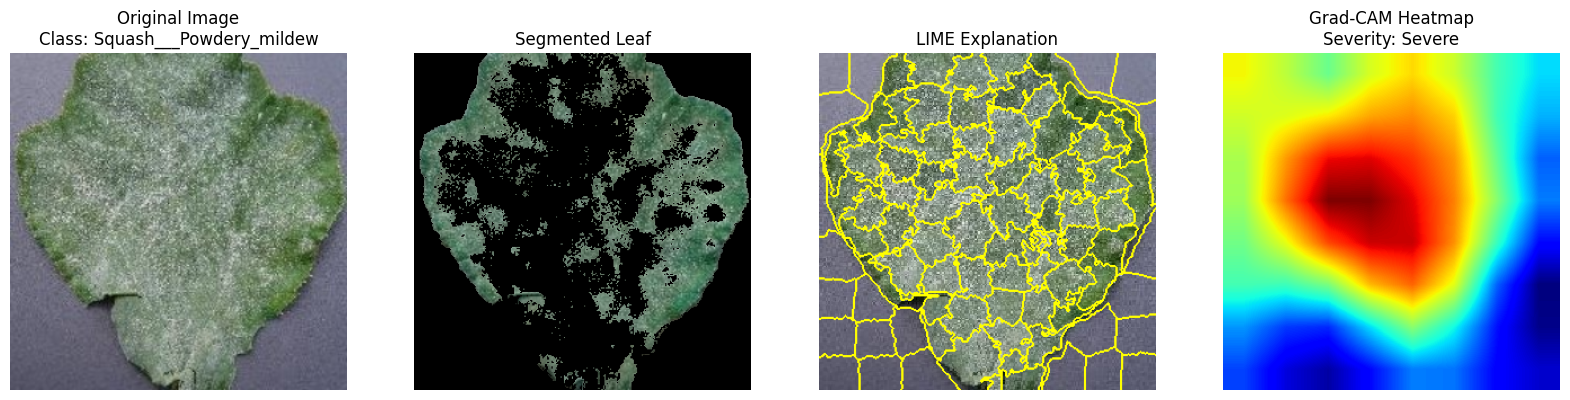

Predicted Class: Squash___Powdery_mildew
Severity Level: Severe
Recommended Treatment: Remove heavily infected leaves and dispose of them away from the garden. Apply a combination of fungicides like Sulfur and Myclobutanil. Improve plant health by fertilizing and watering appropriately. Consider planting resistant varieties in the future. Maintain strict sanitation practices, including cleaning tools and removing fallen debris, to prevent further spread.


In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from skimage.segmentation import slic, mark_boundaries
from lime import lime_image
from skimage.color import label2rgb

# Load the trained model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5", compile=False)
#READ AND RETRIVE INFORMATION
# Load treatment data from Excel
treatment_df = pd.read_excel(r"C:\Users\USER\Desktop\plant_disease_treatments.xlsx", sheet_name="plant_disease_treatments(data)")

# Image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299

# Function to get class names
def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    return {idx: class_name for idx, class_name in enumerate(classes)}

train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"
class_names = get_class_names_from_directory(train_data_folder)

# Preprocess image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

# Leaf segmentation
def segment_leaf(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Green color range for segmentation
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])
    
    mask = cv2.inRange(hsv, lower_green, upper_green)  # Mask for leaf area
    segmented_img = cv2.bitwise_and(img, img, mask=mask)  # Apply mask to original image
    
    return mask, segmented_img, img

# Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name='mixed10'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))

# Severity calculation
def calculate_severity(leaf_mask, heatmap):
    heatmap_threshold = 0.6
    heatmap_mask = (heatmap > heatmap_threshold).astype(np.uint8)
    
    heatmap_coverage = np.sum(heatmap_mask * (leaf_mask > 0))
    leaf_coverage = np.sum(leaf_mask > 0)
    
    if leaf_coverage == 0:
        return "Unknown", 0.0
    
    coverage_ratio = (heatmap_coverage / leaf_coverage) * 100
    
    if coverage_ratio >= 50:
        return "Severe", coverage_ratio
    elif 30 <= coverage_ratio < 50:
        return "Moderate", coverage_ratio
    else:
        return "Mild", coverage_ratio

# LIME XAI with segmentation
def explain_with_lime(image_path, model):
    def preprocess_for_lime(img):
        return np.expand_dims(img / 255.0, axis=0)
    
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img) / 255.0
    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_array, model.predict, top_labels=1, hide_color=0, num_samples=1000)
    
    segments = slic(img_array, n_segments=100, compactness=10, sigma=1)
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    lime_result = mark_boundaries(temp, segments, color=(1, 1, 0))  # Yellow boundaries
    
    return lime_result
#SEVERITY BASED TREATMENT
# Get treatment recommendation
def get_treatment_recommendation(disease, severity):
    treatment_row = treatment_df[(treatment_df['Disease'] == disease) & (treatment_df['Severity'] == severity)]
    if not treatment_row.empty:
        return treatment_row.iloc[0]['Treatment']
    else:
        return "No specific treatment found."

# Predict and display results
def predict_and_display(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names.get(predicted_class, "Unknown")
    
    if "healthy" in class_name.lower():
        print(f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}")
        print("Leaf is Healthy. No disease detected.")
        return
    
    leaf_mask, segmented_img, resized_img = segment_leaf(image_path)
    heatmap = generate_gradcam_heatmap(model, img_array, predicted_class)
    severity, heatmap_coverage = calculate_severity(leaf_mask, heatmap)
    treatment = get_treatment_recommendation(class_name, severity)
    lime_explanation = explain_with_lime(image_path, model)
    
    plt.figure(figsize=(20, 6))
    
    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nClass: {class_name}")
    plt.axis('off')

    # Segmented Leaf Image
    plt.subplot(1, 4, 2)
    plt.imshow(segmented_img)
    plt.title("Segmented Leaf")
    plt.axis('off')

    # LIME Explanation
    plt.subplot(1, 4, 3)
    plt.imshow(lime_explanation)
    plt.title("LIME Explanation")
    plt.axis('off')

    # Grad-CAM Heatmap
    plt.subplot(1, 4, 4)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM Heatmap\nSeverity: {severity}")
    plt.axis('off')

    plt.show()
    
    print(f"Predicted Class: {class_name}")
    print(f"Severity Level: {severity}")
    print(f"Recommended Treatment: {treatment}")

# Example usage
image_path = r"C:\Users\USER\Pictures\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG"
predict_and_display(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Expected LSTM Input Shape: (None, 10, 2)
Actual Input Shape Before Prediction: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
Disease Spread Severity: 3.36 (Scale 0-5)
Confidence: 94.77%


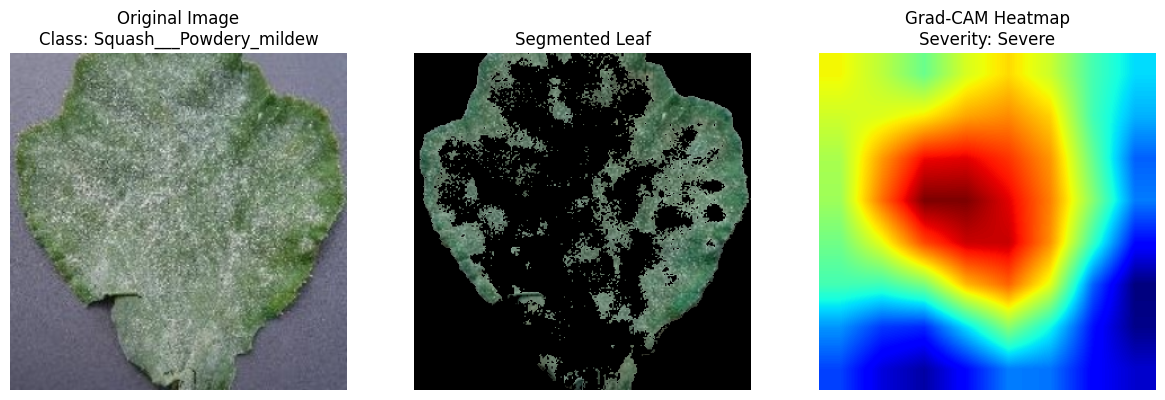

Predicted Class: Squash___Powdery_mildew
Severity Level: Severe
Recommended Treatment: Remove heavily infected leaves and dispose of them away from the garden. Apply a combination of fungicides like Sulfur and Myclobutanil. Improve plant health by fertilizing and watering appropriately. Consider planting resistant varieties in the future. Maintain strict sanitation practices, including cleaning tools and removing fallen debris, to prevent further spread.

Severity Growth: 3.36
Confidence: 94.77%


In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from skimage.segmentation import slic, mark_boundaries
from lime import lime_image
from skimage.color import label2rgb
from keras.models import load_model

# Load the trained image classification model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5", compile=False)

# Load treatment data from Excel
treatment_df = pd.read_excel(r"C:\Users\USER\Desktop\plant_disease_treatments.xlsx", sheet_name="plant_disease_treatments(data)")

# Load the LSTM spread prediction model
lstm_model = load_model(r"C:\Users\USER\Desktop\Project2\lstm_model.h5", compile=False)

# Load synthetic time-series dataset
time_series_df = pd.read_csv(r"C:\Users\USER\Downloads\synthetic_time_series.csv")

# Image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299

# Function to get class names
def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    return {idx: class_name for idx, class_name in enumerate(classes)}

train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"
class_names = get_class_names_from_directory(train_data_folder)

# Preprocess image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

# Leaf segmentation
def segment_leaf(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    segmented_img = cv2.bitwise_and(img, img, mask=mask)
    return mask, segmented_img, img

# Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name='mixed10'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))

# Severity calculation
def calculate_severity(leaf_mask, heatmap):
    heatmap_threshold = 0.6
    heatmap_mask = (heatmap > heatmap_threshold).astype(np.uint8)
    heatmap_coverage = np.sum(heatmap_mask * (leaf_mask > 0))
    leaf_coverage = np.sum(leaf_mask > 0)
    
    if leaf_coverage == 0:
        return "Unknown", 0.0
    
    coverage_ratio = (heatmap_coverage / leaf_coverage) * 100
    if coverage_ratio >= 50:
        return "Severe", coverage_ratio
    elif 30 <= coverage_ratio < 50:
        return "Moderate", coverage_ratio
    else:
        return "Mild", coverage_ratio

# Get treatment recommendation
def get_treatment_recommendation(disease, severity):
    treatment_row = treatment_df[(treatment_df['Disease'] == disease) & (treatment_df['Severity'] == severity)]
    if not treatment_row.empty:
        return treatment_row.iloc[0]['Treatment']
    else:
        return "No specific treatment found."

# Disease spread prediction using LSTM
def predict_disease_spread(disease, severity):
    if disease not in time_series_df['Disease'].unique():
        return "No spread data available"
    
    disease_data = time_series_df[time_series_df['Disease'] == disease]
    severity_index = {"Mild": 0, "Moderate": 1, "Severe": 2}
    
    if severity not in severity_index:
        return "Invalid severity level"
    
    start_index = severity_index[severity]
    #FORGET GATE
    # Ensure we have enough data for 10 time steps
    if len(disease_data) < start_index + 10:
        print(f"Not enough time-series data for {disease} with severity {severity}.")
        return "Insufficient data"
    #INPUT GATE
    # Select correct columns (Ensure there are enough features)
    # Select last 2 numerical columns to match expected input shape
    input_sequence = disease_data.iloc[start_index:start_index+10, -2:].values  # Pick last 2 columns

    input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension

    # Debugging
    print(f"Expected LSTM Input Shape: {lstm_model.input_shape}")
    print(f"Actual Input Shape Before Prediction: {input_sequence.shape}")

    # Ensure the feature dimension matches the LSTM model
    expected_features = lstm_model.input_shape[-1]
    if input_sequence.shape[-1] != expected_features:
        print(f"Feature mismatch! Model expects {expected_features}, but got {input_sequence.shape[-1]}")
        return "Feature dimension mismatch"
    #OUTPUT GATE
    # Now, predict
    spread_prediction = lstm_model.predict(input_sequence)

    # Extract prediction values
    severity_growth, confidence = spread_prediction.flatten()

    return severity_growth, confidence  # Return both values instead of just spread_prediction


# Predict and display results
def predict_and_display(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names.get(predicted_class, "Unknown")
    
    if "healthy" in class_name.lower():
        print(f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}")
        print("Leaf is Healthy. No disease detected.")
        return
    
    leaf_mask, segmented_img, resized_img = segment_leaf(image_path)
    heatmap = generate_gradcam_heatmap(model, img_array, predicted_class)
    severity, heatmap_coverage = calculate_severity(leaf_mask, heatmap)
    treatment = get_treatment_recommendation(class_name, severity)
    spread_prediction = predict_disease_spread(class_name, severity)

    # Check if `spread_prediction` is a tuple before unpacking
    if isinstance(spread_prediction, tuple) and len(spread_prediction) == 2:
        severity_growth, confidence = spread_prediction
        print(f"Disease Spread Severity: {severity_growth:.2f} (Scale 0-5)")
        print(f"Confidence: {confidence:.2%}")
    else:
        severity_growth = "N/A"
        confidence = "N/A"
        print(f"Spread Prediction: {spread_prediction}")

    # Visualization
    plt.figure(figsize=(20, 6))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nClass: {class_name}")
    plt.axis('off')

    # Segmented Leaf Image
    plt.subplot(1, 4, 2)
    plt.imshow(segmented_img)
    plt.title("Segmented Leaf")
    plt.axis('off')

    # Grad-CAM Heatmap
    plt.subplot(1, 4, 3)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM Heatmap\nSeverity: {severity}")
    plt.axis('off')

    plt.show()
    
    print(f"Predicted Class: {class_name}")
    print(f"Severity Level: {severity}")
    print(f"Recommended Treatment: {treatment}")
    print("")
    print(f"Severity Growth: {severity_growth:.2f}")
    print(f"Confidence: {confidence*100:.2f}%")

# Example usage
image_path = r"C:\Users\USER\Pictures\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG"
predict_and_display(image_path, model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Expected LSTM Input Shape: (None, 10, 2)
Actual Input Shape Before Prediction: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
Disease Spread Severity: 3.36 (Scale 0-5)
Confidence: 94.77%


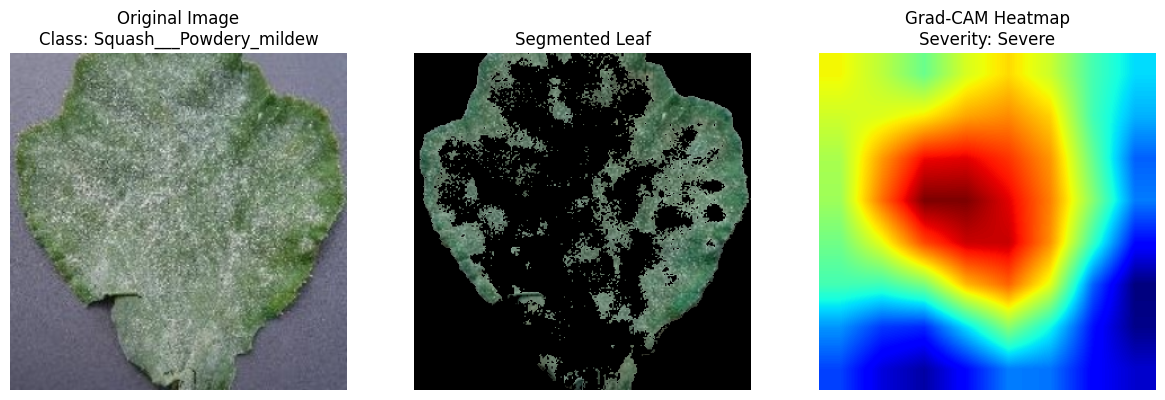

Predicted Class: Squash___Powdery_mildew
Severity Level: Severe
Recommended Treatment: Remove heavily infected leaves and dispose of them away from the garden. Apply a combination of fungicides like Sulfur and Myclobutanil. Improve plant health by fertilizing and watering appropriately. Consider planting resistant varieties in the future. Maintain strict sanitation practices, including cleaning tools and removing fallen debris, to prevent further spread.
Disease Spread Severity: 3.36 (Scale 0-5)
Confidence: 94.77%


Do you want to generate a report? (yes/no):  yes


Report generated and saved as Plant_Disease_Report_test1.pdf


In [13]:
#report gen

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from skimage.segmentation import slic, mark_boundaries
from lime import lime_image
from skimage.color import label2rgb
from keras.models import load_model
from fpdf import FPDF

# ------------------------------
# Load Models and Data
# ------------------------------
# Load the trained image classification model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5", compile=False)

# Load treatment data from Excel
treatment_df = pd.read_excel(r"C:\Users\USER\Desktop\plant_disease_treatments.xlsx", sheet_name="plant_disease_treatments(data)")

# Load the LSTM spread prediction model
lstm_model = load_model(r"C:\Users\USER\Desktop\Project2\lstm_model.h5", compile=False)

# Load synthetic time-series dataset
time_series_df = pd.read_csv(r"C:\Users\USER\Downloads\synthetic_time_series.csv")

# Image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299

# Get class names from test folder structure
def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    return {idx: class_name for idx, class_name in enumerate(classes)}

train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"
class_names = get_class_names_from_directory(train_data_folder)

# ------------------------------
# Preprocessing and Utility Functions
# ------------------------------
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

def segment_leaf(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    segmented_img = cv2.bitwise_and(img, img, mask=mask)
    return mask, segmented_img, img

def generate_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name='mixed10'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))

def calculate_severity(leaf_mask, heatmap):
    heatmap_threshold = 0.6
    heatmap_mask = (heatmap > heatmap_threshold).astype(np.uint8)
    heatmap_coverage = np.sum(heatmap_mask * (leaf_mask > 0))
    leaf_coverage = np.sum(leaf_mask > 0)
    if leaf_coverage == 0:
        return "Unknown", 0.0
    coverage_ratio = (heatmap_coverage / leaf_coverage) * 100
    if coverage_ratio >= 50:
        return "Severe", coverage_ratio
    elif 30 <= coverage_ratio < 50:
        return "Moderate", coverage_ratio
    else:
        return "Mild", coverage_ratio

def get_treatment_recommendation(disease, severity):
    treatment_row = treatment_df[(treatment_df['Disease'] == disease) & (treatment_df['Severity'] == severity)]
    if not treatment_row.empty:
        return treatment_row.iloc[0]['Treatment']
    else:
        return "No specific treatment found."

def predict_disease_spread(disease, severity):
    if disease not in time_series_df['Disease'].unique():
        return "No spread data available"
    disease_data = time_series_df[time_series_df['Disease'] == disease]
    severity_index = {"Mild": 0, "Moderate": 1, "Severe": 2}
    if severity not in severity_index:
        return "Invalid severity level"
    start_index = severity_index[severity]
    if len(disease_data) < start_index + 10:
        print(f"Not enough time-series data for {disease} with severity {severity}.")
        return "Insufficient data"
    input_sequence = disease_data.iloc[start_index:start_index+10, -2:].values  # Adjust feature columns as required
    input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension
    print(f"Expected LSTM Input Shape: {lstm_model.input_shape}")
    print(f"Actual Input Shape Before Prediction: {input_sequence.shape}")
    expected_features = lstm_model.input_shape[-1]
    if input_sequence.shape[-1] != expected_features:
        print(f"Feature mismatch! Model expects {expected_features}, but got {input_sequence.shape[-1]}")
        return "Feature dimension mismatch"
    spread_prediction = lstm_model.predict(input_sequence)
    severity_growth, confidence = spread_prediction.flatten()
    return severity_growth, confidence

# ------------------------------
# Main Prediction and Display Function
# ------------------------------
def predict_and_display(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names.get(predicted_class, "Unknown")
    
    results = {}  # Dictionary to store outputs for the report
    
    if "healthy" in class_name.lower():
        msg = f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}\nLeaf is Healthy. No disease detected."
        print(msg)
        results['summary'] = msg
        return results
    
    leaf_mask, segmented_img, resized_img = segment_leaf(image_path)
    heatmap = generate_gradcam_heatmap(model, img_array, predicted_class)
    severity, heatmap_coverage = calculate_severity(leaf_mask, heatmap)
    treatment = get_treatment_recommendation(class_name, severity)
    spread_prediction = predict_disease_spread(class_name, severity)

    if isinstance(spread_prediction, tuple) and len(spread_prediction) == 2:
        severity_growth, confidence = spread_prediction
        spread_str = f"Disease Spread Severity: {severity_growth:.2f} (Scale 0-5)\nConfidence: {confidence:.2%}"
        print(spread_str)
    else:
        severity_growth = "N/A"
        confidence = "N/A"
        spread_str = f"Spread Prediction: {spread_prediction}"
        print(spread_str)

    # Visualization
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nClass: {class_name}")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(segmented_img)
    plt.title("Segmented Leaf")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM Heatmap\nSeverity: {severity}")
    plt.axis('off')
    plt.show()

    output_str = (f"Predicted Class: {class_name}\n"
                  f"Severity Level: {severity}\n"
                  f"Recommended Treatment: {treatment}\n"
                  f"{spread_str}")
    
    print(output_str)
    
    # Store outputs for report generation
    results['predicted_class'] = class_name
    results['severity'] = severity
    results['treatment'] = treatment
    results['spread'] = spread_str
    results['output_str'] = output_str
    results['original_image'] = resized_img
    results['segmented_image'] = segmented_img
    results['heatmap'] = heatmap
    
    return results

# ------------------------------
# PDF Report Generation Function using FPDF
# ------------------------------
class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, 'Plant Disease Diagnosis Report', ln=True, align='C')
        self.ln(10)
        
    def chapter_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, title, ln=True)
        self.ln(4)
        
    def chapter_body(self, body_text):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body_text)
        self.ln()
        
    def add_image_section(self, image_path, title, w=100):
        self.chapter_title(title)
        self.image(image_path, w=w)
        self.ln()

def generate_pdf_report(results, report_filename="Plant_Disease_Report_test1.pdf"):
    pdf = PDFReport()
    pdf.add_page()
    pdf.chapter_title("Diagnosis Summary")
    pdf.chapter_body(results.get('output_str', 'No details available.'))
    
    # Save temporary images for report
    temp_folder = "temp_report_images"
    os.makedirs(temp_folder, exist_ok=True)
    orig_img_path = os.path.join(temp_folder, "original.png")
    seg_img_path = os.path.join(temp_folder, "segmented.png")
    heatmap_path = os.path.join(temp_folder, "heatmap.png")
    
    # Write images using matplotlib (or cv2)
    plt.imsave(orig_img_path, cv2.cvtColor(results['original_image'], cv2.COLOR_BGR2RGB))
    plt.imsave(seg_img_path, results['segmented_image'])
    plt.imsave(heatmap_path, results['heatmap'], cmap='jet')
    
    pdf.add_image_section(orig_img_path, "Original Image")
    pdf.add_image_section(seg_img_path, "Segmented Leaf")
    pdf.add_image_section(heatmap_path, "Grad-CAM Heatmap")
    
    pdf.output(report_filename)
    print(f"Report generated and saved as {report_filename}")

# ------------------------------
# Main Execution Flow
# ------------------------------
if __name__ == "__main__":
    # Provide the image path you want to analyze
    image_path = r"C:\Users\USER\Pictures\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG"
    results = predict_and_display(image_path, model)
    
    # Ask user if they want to generate a report
    user_input = input("Do you want to generate a report? (yes/no): ").strip().lower()
    if user_input in ['yes', 'y']:
        generate_pdf_report(results)
    else:
        print("Report generation skipped.")


In [2]:
#llm using api key
import requests

# Replace with your actual API key
api_key = "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"  # Replace with your actual API key

# Set up the URL for the API
url = "https://openrouter.ai/api/v1/chat/completions"  # This URL might need to be different

# Headers for the request
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

def chat_with_model():
    print("Start chatting (type 'quit' to end):")
    while True:
        # User input
        user_input = input("You: ")
        if user_input.lower() == "quit":
            print("Ending the chat...")
            break
        
        # Create the payload for the request
        payload = {
            "model": "gpt-3.5-turbo",  # Test with a known model like gpt-3.5-turbo
            "messages": [
                {"role": "user", "content": user_input}
            ]
        }

        # Send request to the API
        response = requests.post(url, json=payload, headers=headers)

        # Check if the response was successful
        if response.status_code == 200:
            response_data = response.json()
            model_reply = response_data['choices'][0]['message']['content']
            print(f"Model: {model_reply}\n")
        else:
            print(f"Error: {response.status_code}")
            print(response.text)

# Start chatting with the model
chat_with_model()


Start chatting (type 'quit' to end):


You:  give some remedy for squash powdery mildew


Model: 1. Neem oil: Neem oil is a natural fungicide that can help control powdery mildew. Mix 2-3 tablespoons of neem oil with a gallon of water and spray it on the affected plants.

2. Baking soda spray: Mix 1 tablespoon of baking soda, 1 tablespoon of vegetable oil, and a few drops of dish soap with a gallon of water. Spray on the plants to help control powdery mildew.

3. Milk spray: Mix one part milk with nine parts water and spray on the affected plants. The proteins in the milk help to control powdery mildew.

4. Prune affected leaves: Prune and remove any infected leaves or parts of the plant to prevent the spread of powdery mildew.

5. Increase air circulation: Ensure proper spacing between plants to allow for good air circulation, which can help prevent the development of powdery mildew.

6. Use powdery mildew-resistant varieties: Consider planting squash varieties that are resistant to powdery mildew to prevent future outbreaks.



You:  quit


Ending the chat...



Do you want to evaluate model performance? (yes/no): 


 yes



--- Evaluating Model Performance ---
Calculating model performance metrics...
Found 5315 images belonging to 38 classes.
Predicting on 167 batches...


C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 681s 4s/step
Calculating metrics...
Generating confusion matrix...

Model Performance Metrics:
Accuracy: 0.9784
Precision: 0.9790
Recall: 0.9784
F1 Score: 0.9783
Confusion matrix has 38 classes. Displaying top 20 for visibility.


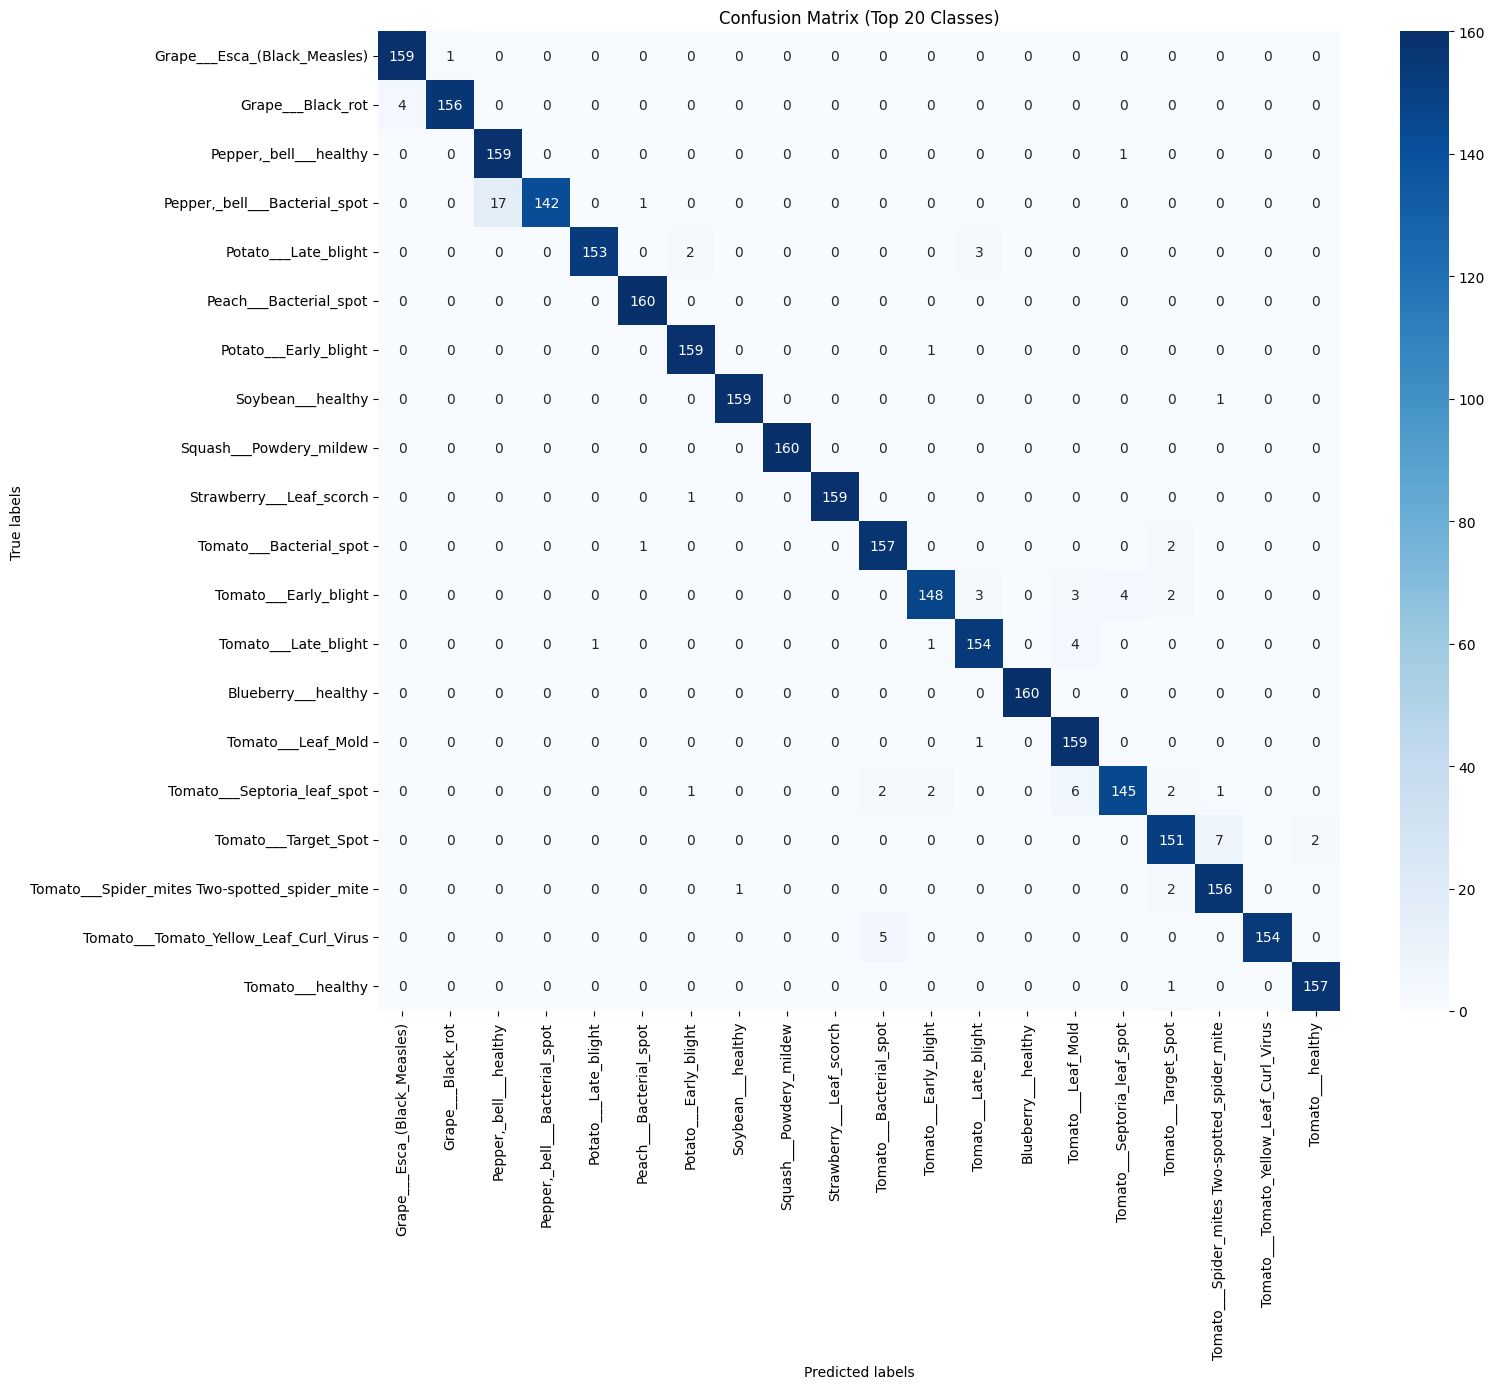

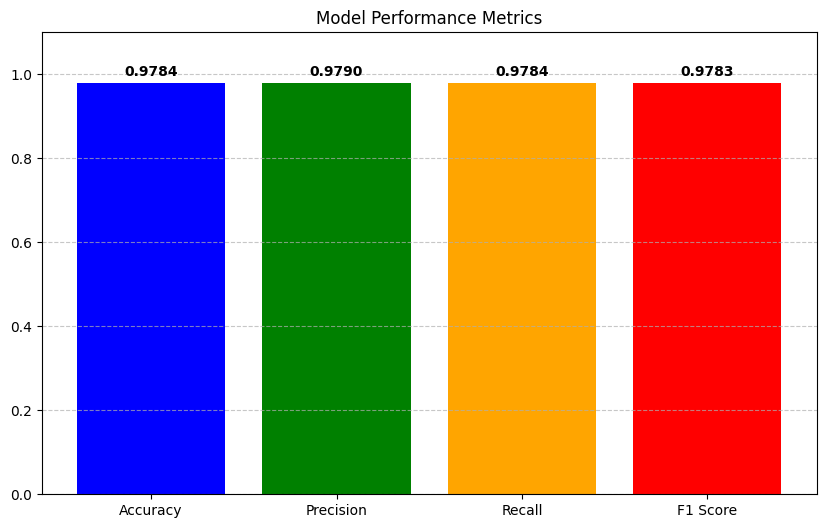


Per-class performance metrics (top 20 classes):
Error during performance evaluation: Number of classes, 24, does not match size of target_names, 20. Try specifying the labels parameter


Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_8580\832965406.py", line 167, in evaluate_model_performance
    accuracy, precision, recall, f1, cm, class_mapping = calculate_model_performance(
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_8580\832965406.py", line 148, in calculate_model_performance
    print(classification_report(y_true_filtered, y_pred_filtered,
  File "C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 2648, in classification_report
    raise ValueError(
ValueError: Number of classes, 24, does not match size of target_names, 20. Try specifying the labels parameter


In [15]:
# ------------------------------
# PERFORMANCE METRICS FUNCTIONS
# ------------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

# IMPORTANT: Define these variables with your actual paths
# These were missing in the previous code
IMG_WIDTH, IMG_HEIGHT = 299, 299   # Inception V3 input dimensions
MODEL_PATH = r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5"
TRAIN_DATA_FOLDER = r"D:\project\25000reduced_dataset_split_dataset\test"

# Load the model (only if not already loaded)
try:
    model  # Check if model is already defined
except NameError:
    print("Loading model from", MODEL_PATH)
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

def get_class_names_from_directory(directory_path):
    """
    Get class names from directory structure
    """
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    class_indices = {class_name: idx for idx, class_name in enumerate(classes)}
    return {v: k for k, v in class_indices.items()}

def calculate_model_performance(model, test_data_dir, class_names_dict, batch_size=32):
    """
    Calculate performance metrics for the model on test data
    """
    print("Calculating model performance metrics...")
    
    # Create data generator for test dataset
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Get actual class indices from generator
    class_indices = test_generator.class_indices
    actual_class_mapping = {v: k for k, v in class_indices.items()}
    
    # Make predictions on test data
    steps = len(test_generator)
    print(f"Predicting on {steps} batches...")
    
    # Use the right number of steps
    y_pred_probas = model.predict(test_generator, steps=steps)
    y_pred = np.argmax(y_pred_probas, axis=1)
    y_true = test_generator.classes
    
    # Ensure arrays have the same length
    y_true = y_true[:len(y_pred)]
    
    # Calculate performance metrics
    print("Calculating metrics...")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Create confusion matrix
    print("Generating confusion matrix...")
    cm = confusion_matrix(y_true, y_pred)
    
    # Print metrics
    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix with limited classes for visibility
    if len(cm) > 20:
        print(f"Confusion matrix has {len(cm)} classes. Displaying top 20 for visibility.")
        # Get top 20 classes by frequency in true labels
        unique_classes, class_counts = np.unique(y_true, return_counts=True)
        top_classes_idx = np.argsort(class_counts)[-20:]
        
        # Filter confusion matrix to only show top classes
        filtered_cm = cm[top_classes_idx][:, top_classes_idx]
        class_labels = [actual_class_mapping[i] for i in top_classes_idx]
        
        plt.figure(figsize=(16, 14))
        sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix (Top 20 Classes)')
        plt.xticks(rotation=90)
        plt.tight_layout()
    else:
        # Plot full confusion matrix if it's a reasonable size
        class_labels = [actual_class_mapping[i] for i in range(len(cm))]
        plt.figure(figsize=(16, 14))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90)
        plt.tight_layout()
    
    # Save and show the plot
    plt.savefig("confusion_matrix.png")
    plt.show()
    
    # Plot metrics as bar chart
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]
    bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.ylim(0, 1.1)
    plt.title('Model Performance Metrics')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("performance_metrics.png")
    plt.show()
    
    # Per-class metrics (limit to top 20 classes by frequency)
    print("\nPer-class performance metrics (top 20 classes):")
    if len(np.unique(y_true)) > 20:
        unique_classes, class_counts = np.unique(y_true, return_counts=True)
        top_classes_idx = np.argsort(class_counts)[-20:]
        
        # Create masks for top classes
        y_true_mask = np.isin(y_true, top_classes_idx)
        y_true_filtered = y_true[y_true_mask]
        y_pred_filtered = y_pred[y_true_mask]
        
        print(classification_report(y_true_filtered, y_pred_filtered, 
                                   target_names=[actual_class_mapping[i] for i in top_classes_idx]))
    else:
        print(classification_report(y_true, y_pred, 
                                   target_names=[actual_class_mapping[i] for i in range(len(cm))]))
    
    return accuracy, precision, recall, f1, cm, actual_class_mapping

def evaluate_model_performance():
    """
    Function to evaluate model performance
    """
    print("\n--- Evaluating Model Performance ---")
    
    try:
        # Load class names
        class_names = get_class_names_from_directory(TRAIN_DATA_FOLDER)
        
        # Calculate performance metrics
        accuracy, precision, recall, f1, cm, class_mapping = calculate_model_performance(
            model, TRAIN_DATA_FOLDER, class_names
        )
        
        # Calculate robustness by testing with noisy images
        print("\n--- Evaluating Model Robustness ---")
        
        # Function to add noise to images
        def add_noise(image):
            noise = np.random.normal(0, 0.1, image.shape)
            noisy_image = image + noise
            return np.clip(noisy_image, 0, 1)  # Ensure values stay in [0,1]
        
        # Create noisy data generator
        print("Creating noisy data generator...")
        noisy_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            preprocessing_function=add_noise
        )
        
        noisy_generator = noisy_datagen.flow_from_directory(
            TRAIN_DATA_FOLDER,
            target_size=(IMG_WIDTH, IMG_HEIGHT),
            batch_size=32,
            class_mode='categorical',
            shuffle=False
        )
        
        # Predict on noisy images
        print("Predicting on noisy images...")
        steps = len(noisy_generator)
        y_pred_noisy = model.predict(noisy_generator, steps=steps)
        y_pred_noisy_classes = np.argmax(y_pred_noisy, axis=1)
        y_true = noisy_generator.classes
        
        # Ensure arrays have the same length
        y_true = y_true[:len(y_pred_noisy_classes)]
        
        # Calculate accuracy on noisy images
        noisy_accuracy = accuracy_score(y_true, y_pred_noisy_classes)
        print(f"Accuracy on noisy images: {noisy_accuracy:.4f}")
        print(f"Robustness score (accuracy ratio): {noisy_accuracy/accuracy:.4f}")
        
        # Add robustness comparison chart
        plt.figure(figsize=(8, 6))
        bars = plt.bar(['Clean Images', 'Noisy Images'], [accuracy, noisy_accuracy], color=['blue', 'orange'])
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
        
        plt.ylim(0, 1.1)
        plt.title('Model Robustness Comparison')
        plt.ylabel('Accuracy')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig("robustness_comparison.png")
        plt.show()
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'noisy_accuracy': noisy_accuracy,
            'robustness_ratio': noisy_accuracy/accuracy
        }
    
    except Exception as e:
        print(f"Error during performance evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main execution
if __name__ == "__main__":
    print("\nDo you want to evaluate model performance? (yes/no): ")
    eval_option = input().strip().lower()
    if eval_option in ['yes', 'y']:
        metrics = evaluate_model_performance()


Do you want to evaluate model performance? (yes/no): 


 yes



--- Evaluating Model Performance ---
Calculating model performance metrics...
Found 5315 images belonging to 38 classes.
Predicting on 167 batches...


C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step
Calculating metrics...
Generating confusion matrix...

Model Performance Metrics:
Accuracy: 0.9784
Precision: 0.9790
Recall: 0.9784
F1 Score: 0.9783
Confusion matrix has 38 classes. Displaying top 20 for visibility.


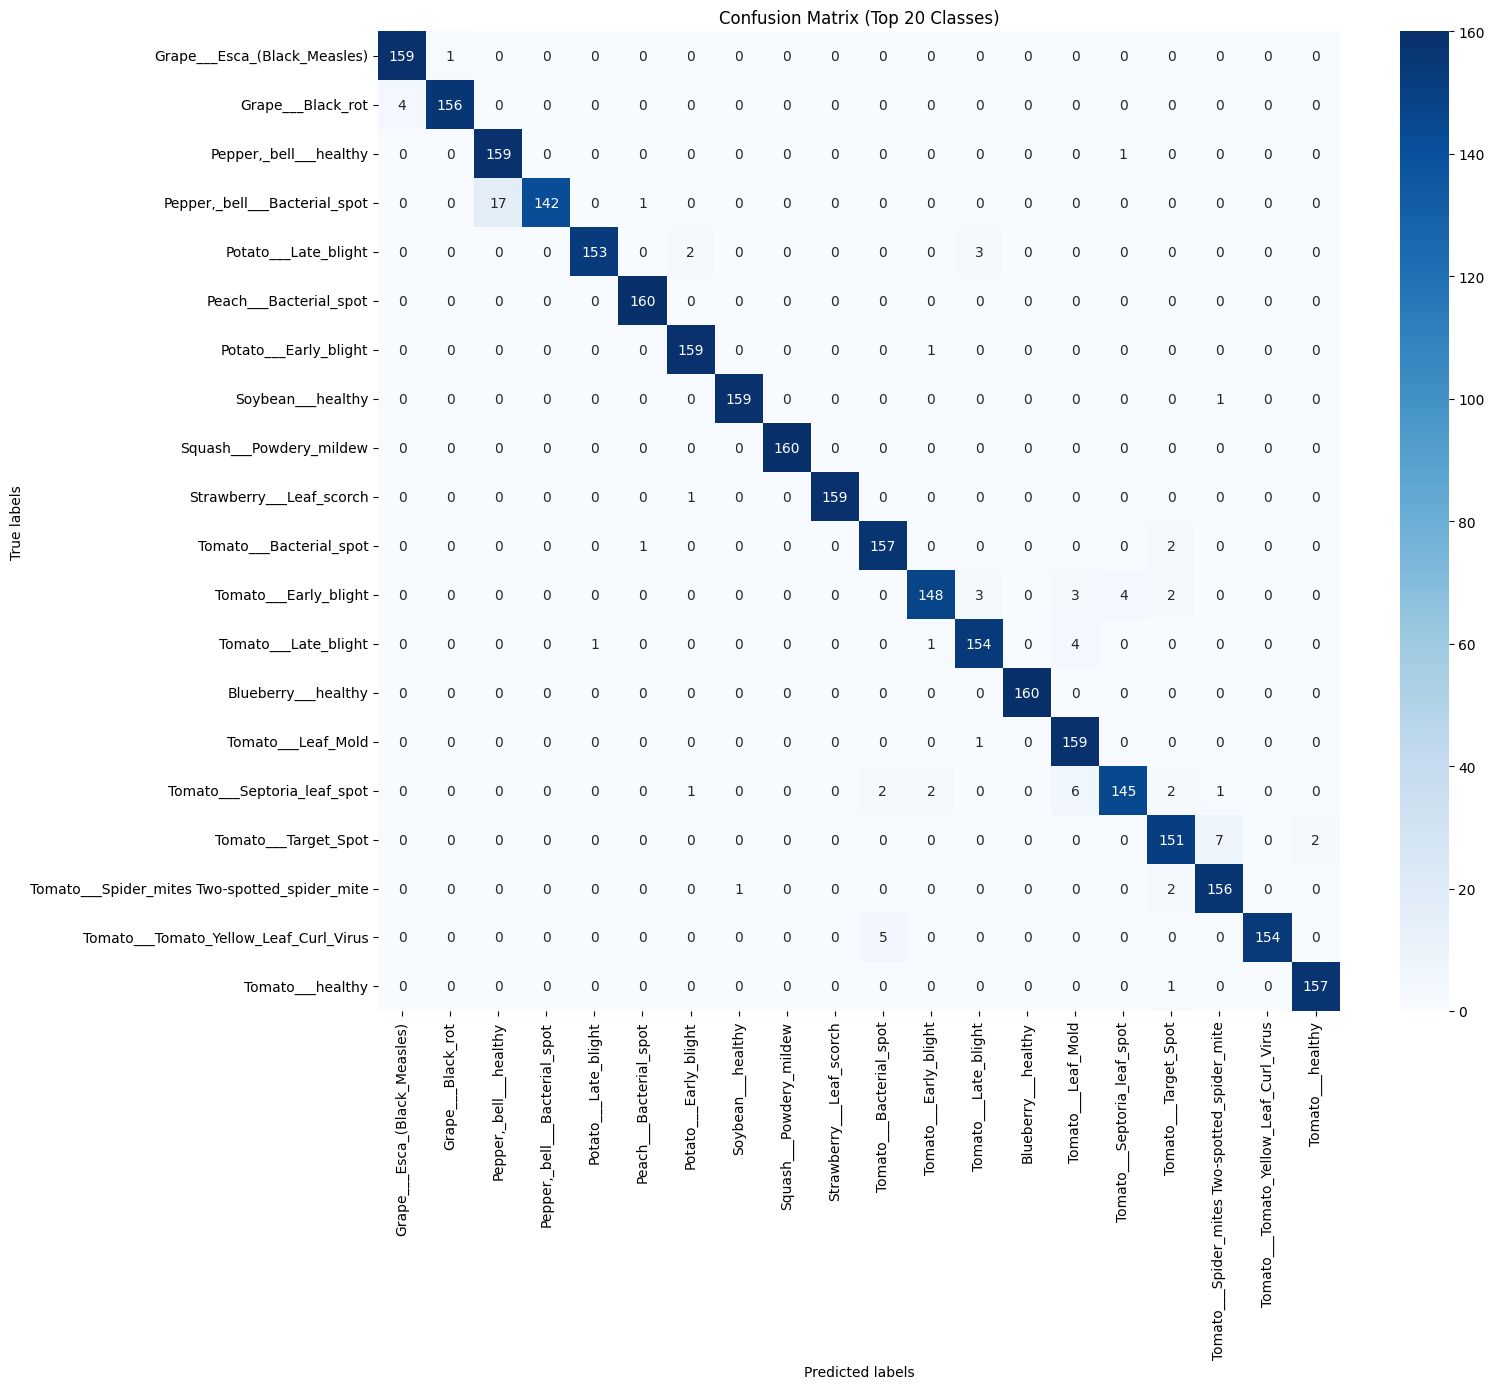

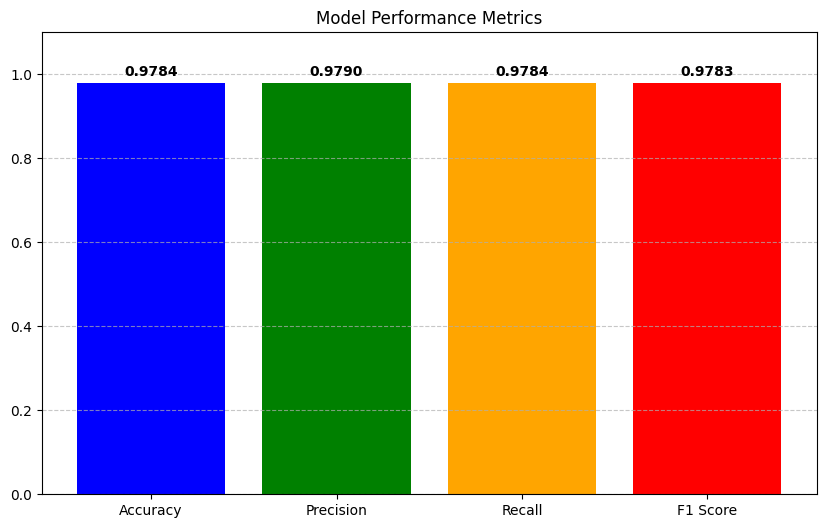


Per-class performance metrics (top 20 classes):
                                               precision    recall  f1-score   support

                 Grape___Esca_(Black_Measles)       0.98      0.99      0.98       160
                            Grape___Black_rot       0.99      0.97      0.98       160
                       Pepper,_bell___healthy       0.90      0.99      0.95       160
                Pepper,_bell___Bacterial_spot       1.00      0.89      0.94       160
                         Potato___Late_blight       0.99      0.96      0.97       160
                       Peach___Bacterial_spot       0.99      1.00      0.99       160
                        Potato___Early_blight       0.98      0.99      0.98       160
                            Soybean___healthy       0.99      0.99      0.99       160
                      Squash___Powdery_mildew       1.00      1.00      1.00       160
                     Strawberry___Leaf_scorch       1.00      0.99      1.00    

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 812s 5s/step
Accuracy on noisy images: 0.0301
Robustness score (accuracy ratio): 0.0308


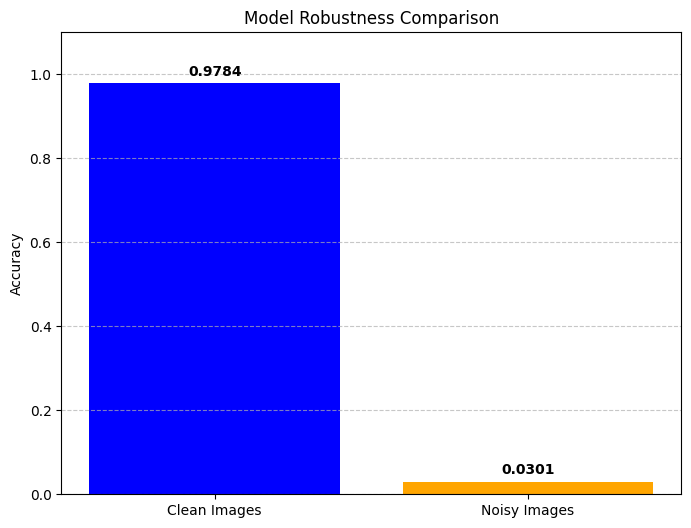

In [16]:
# ------------------------------
# PERFORMANCE METRICS FUNCTIONS
# ------------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

# IMPORTANT: Define these variables with your actual paths
# These were missing in the previous code
IMG_WIDTH, IMG_HEIGHT = 299, 299   # Inception V3 input dimensions
MODEL_PATH = r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5"
TRAIN_DATA_FOLDER = r"D:\project\25000reduced_dataset_split_dataset\test"

# Load the model (only if not already loaded)
try:
    model  # Check if model is already defined
except NameError:
    print("Loading model from", MODEL_PATH)
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

def get_class_names_from_directory(directory_path):
    """
    Get class names from directory structure
    """
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    class_indices = {class_name: idx for idx, class_name in enumerate(classes)}
    return {v: k for k, v in class_indices.items()}

def calculate_model_performance(model, test_data_dir, class_names_dict, batch_size=32):
    """
    Calculate performance metrics for the model on test data
    """
    print("Calculating model performance metrics...")
    
    # Create data generator for test dataset
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Get actual class indices from generator
    class_indices = test_generator.class_indices
    actual_class_mapping = {v: k for k, v in class_indices.items()}
    
    # Make predictions on test data
    steps = len(test_generator)
    print(f"Predicting on {steps} batches...")
    
    # Use the right number of steps
    y_pred_probas = model.predict(test_generator, steps=steps)
    y_pred = np.argmax(y_pred_probas, axis=1)
    y_true = test_generator.classes
    
    # Ensure arrays have the same length
    y_true = y_true[:len(y_pred)]
    
    # Calculate performance metrics
    print("Calculating metrics...")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Create confusion matrix
    print("Generating confusion matrix...")
    cm = confusion_matrix(y_true, y_pred)
    
    # Print metrics
    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix with limited classes for visibility
    if len(cm) > 20:
        print(f"Confusion matrix has {len(cm)} classes. Displaying top 20 for visibility.")
        # Get top 20 classes by frequency in true labels
        unique_classes, class_counts = np.unique(y_true, return_counts=True)
        top_classes_idx = np.argsort(class_counts)[-20:]
        
        # Filter confusion matrix to only show top classes
        filtered_cm = cm[top_classes_idx][:, top_classes_idx]
        class_labels = [actual_class_mapping[i] for i in top_classes_idx]
        
        plt.figure(figsize=(16, 14))
        sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix (Top 20 Classes)')
        plt.xticks(rotation=90)
        plt.tight_layout()
    else:
        # Plot full confusion matrix if it's a reasonable size
        class_labels = [actual_class_mapping[i] for i in range(len(cm))]
        plt.figure(figsize=(16, 14))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90)
        plt.tight_layout()
    
    # Save and show the plot
    plt.savefig("confusion_matrix.png")
    plt.show()
    
    # Plot metrics as bar chart
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]
    bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.ylim(0, 1.1)
    plt.title('Model Performance Metrics')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("performance_metrics.png")
    plt.show()
    
    # Per-class metrics (limit to top 20 classes by frequency)
    print("\nPer-class performance metrics (top 20 classes):")
    if len(np.unique(y_true)) > 20:
        unique_classes, class_counts = np.unique(y_true, return_counts=True)
        top_classes_idx = np.argsort(class_counts)[-20:]
        
        # Create masks for top classes
        y_true_mask = np.isin(y_true, top_classes_idx)
        y_true_filtered = y_true[y_true_mask]
        y_pred_filtered = y_pred[y_true_mask]
        
        # Added the labels parameter to specify exactly which classes to include
        print(classification_report(y_true_filtered, y_pred_filtered, 
                                   labels=top_classes_idx,  # This fixes the error
                                   target_names=[actual_class_mapping[i] for i in top_classes_idx]))
    else:
        print(classification_report(y_true, y_pred, 
                                   target_names=[actual_class_mapping[i] for i in range(len(cm))]))
    
    return accuracy, precision, recall, f1, cm, actual_class_mapping

def evaluate_model_performance():
    """
    Function to evaluate model performance
    """
    print("\n--- Evaluating Model Performance ---")
    
    try:
        # Load class names
        class_names = get_class_names_from_directory(TRAIN_DATA_FOLDER)
        
        # Calculate performance metrics
        accuracy, precision, recall, f1, cm, class_mapping = calculate_model_performance(
            model, TRAIN_DATA_FOLDER, class_names
        )
        
        # Calculate robustness by testing with noisy images
        print("\n--- Evaluating Model Robustness ---")
        
        # Function to add noise to images
        def add_noise(image):
            noise = np.random.normal(0, 0.1, image.shape)
            noisy_image = image + noise
            return np.clip(noisy_image, 0, 1)  # Ensure values stay in [0,1]
        
        # Create noisy data generator
        print("Creating noisy data generator...")
        noisy_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            preprocessing_function=add_noise
        )
        
        noisy_generator = noisy_datagen.flow_from_directory(
            TRAIN_DATA_FOLDER,
            target_size=(IMG_WIDTH, IMG_HEIGHT),
            batch_size=32,
            class_mode='categorical',
            shuffle=False
        )
        
        # Predict on noisy images
        print("Predicting on noisy images...")
        steps = len(noisy_generator)
        y_pred_noisy = model.predict(noisy_generator, steps=steps)
        y_pred_noisy_classes = np.argmax(y_pred_noisy, axis=1)
        y_true = noisy_generator.classes
        
        # Ensure arrays have the same length
        y_true = y_true[:len(y_pred_noisy_classes)]
        
        # Calculate accuracy on noisy images
        noisy_accuracy = accuracy_score(y_true, y_pred_noisy_classes)
        print(f"Accuracy on noisy images: {noisy_accuracy:.4f}")
        print(f"Robustness score (accuracy ratio): {noisy_accuracy/accuracy:.4f}")
        
        # Add robustness comparison chart
        plt.figure(figsize=(8, 6))
        bars = plt.bar(['Clean Images', 'Noisy Images'], [accuracy, noisy_accuracy], color=['blue', 'orange'])
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
        
        plt.ylim(0, 1.1)
        plt.title('Model Robustness Comparison')
        plt.ylabel('Accuracy')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig("robustness_comparison.png")
        plt.show()
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'noisy_accuracy': noisy_accuracy,
            'robustness_ratio': noisy_accuracy/accuracy
        }
    
    except Exception as e:
        print(f"Error during performance evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main execution
if __name__ == "__main__":
    print("\nDo you want to evaluate model performance? (yes/no): ")
    eval_option = input().strip().lower()
    if eval_option in ['yes', 'y']:
        metrics = evaluate_model_performance()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Expected LSTM Input Shape: (None, 10, 2)
Actual Input Shape Before Prediction: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
Disease Spread Severity: 3.36 (Scale 0-5)
Confidence: 94.77%


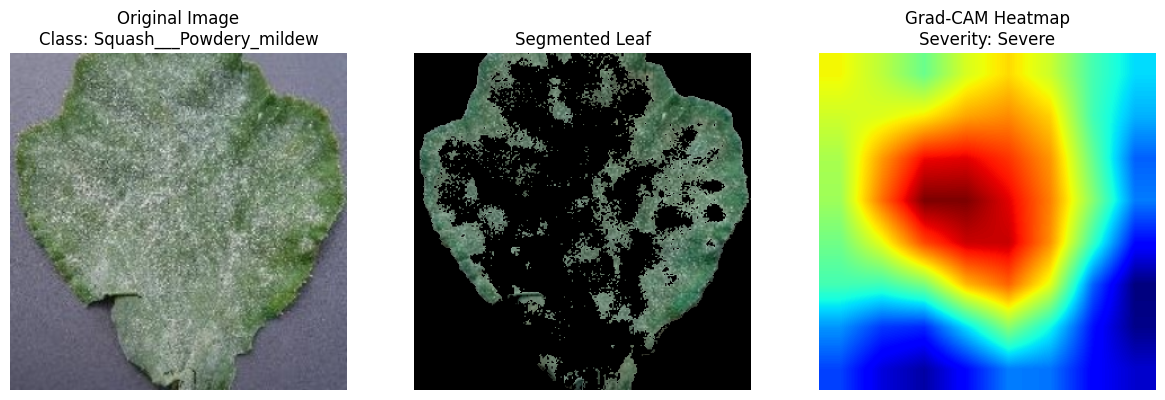

Predicted Class: Squash___Powdery_mildew
Severity Level: Severe
Recommended Treatment: Remove heavily infected leaves and dispose of them away from the garden. Apply a combination of fungicides like Sulfur and Myclobutanil. Improve plant health by fertilizing and watering appropriately. Consider planting resistant varieties in the future. Maintain strict sanitation practices, including cleaning tools and removing fallen debris, to prevent further spread.
Disease Spread Severity: 3.36 (Scale 0-5)
Confidence: 94.77%


Do you want to generate a report? (yes/no):  yes


Report generated and saved as Plant_Disease_Report_test1.pdf


In [2]:
#report gen

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from skimage.segmentation import slic, mark_boundaries
from lime import lime_image
from skimage.color import label2rgb
from keras.models import load_model
from fpdf import FPDF

# ------------------------------
# Load Models and Data
# ------------------------------
# Load the trained image classification model
model = tf.keras.models.load_model(r"C:\Users\USER\Desktop\Project2\inception_model_trained.h5", compile=False)

# Load treatment data from Excel
treatment_df = pd.read_excel(r"C:\Users\USER\Desktop\plant_disease_treatments.xlsx", sheet_name="plant_disease_treatments(data)")

# Load the LSTM spread prediction model
lstm_model = load_model(r"C:\Users\USER\Desktop\Project2\lstm_model.h5", compile=False)

# Load synthetic time-series dataset
time_series_df = pd.read_csv(r"C:\Users\USER\Downloads\synthetic_time_series.csv")

# Image properties
IMG_WIDTH, IMG_HEIGHT = 299, 299

# Get class names from test folder structure
def get_class_names_from_directory(directory_path):
    classes = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])
    return {idx: class_name for idx, class_name in enumerate(classes)}

train_data_folder = r"D:\project\25000reduced_dataset_split_dataset\test"
class_names = get_class_names_from_directory(train_data_folder)

# ------------------------------
# Preprocessing and Utility Functions
# ------------------------------
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

def segment_leaf(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    segmented_img = cv2.bitwise_and(img, img, mask=mask)
    return mask, segmented_img, img

def generate_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name='mixed10'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))

def calculate_severity(leaf_mask, heatmap):
    heatmap_threshold = 0.6
    heatmap_mask = (heatmap > heatmap_threshold).astype(np.uint8)
    heatmap_coverage = np.sum(heatmap_mask * (leaf_mask > 0))
    leaf_coverage = np.sum(leaf_mask > 0)
    if leaf_coverage == 0:
        return "Unknown", 0.0
    coverage_ratio = (heatmap_coverage / leaf_coverage) * 100
    if coverage_ratio >= 50:
        return "Severe", coverage_ratio
    elif 30 <= coverage_ratio < 50:
        return "Moderate", coverage_ratio
    else:
        return "Mild", coverage_ratio

def get_treatment_recommendation(disease, severity):
    treatment_row = treatment_df[(treatment_df['Disease'] == disease) & (treatment_df['Severity'] == severity)]
    if not treatment_row.empty:
        return treatment_row.iloc[0]['Treatment']
    else:
        return "No specific treatment found."

def predict_disease_spread(disease, severity):
    if disease not in time_series_df['Disease'].unique():
        return "No spread data available"
    disease_data = time_series_df[time_series_df['Disease'] == disease]
    severity_index = {"Mild": 0, "Moderate": 1, "Severe": 2}
    if severity not in severity_index:
        return "Invalid severity level"
    start_index = severity_index[severity]
    if len(disease_data) < start_index + 10:
        print(f"Not enough time-series data for {disease} with severity {severity}.")
        return "Insufficient data"
    input_sequence = disease_data.iloc[start_index:start_index+10, -2:].values  # Adjust feature columns as required
    input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension
    print(f"Expected LSTM Input Shape: {lstm_model.input_shape}")
    print(f"Actual Input Shape Before Prediction: {input_sequence.shape}")
    expected_features = lstm_model.input_shape[-1]
    if input_sequence.shape[-1] != expected_features:
        print(f"Feature mismatch! Model expects {expected_features}, but got {input_sequence.shape[-1]}")
        return "Feature dimension mismatch"
    spread_prediction = lstm_model.predict(input_sequence)
    severity_growth, confidence = spread_prediction.flatten()
    return severity_growth, confidence

# ------------------------------
# Main Prediction and Display Function
# ------------------------------
def predict_and_display(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names.get(predicted_class, "Unknown")
    
    results = {}  # Dictionary to store outputs for the report
    
    if "healthy" in class_name.lower():
        msg = f"Image: {os.path.basename(image_path)} --> Predicted Class: {class_name}\nLeaf is Healthy. No disease detected."
        print(msg)
        results['summary'] = msg
        return results
    
    leaf_mask, segmented_img, resized_img = segment_leaf(image_path)
    heatmap = generate_gradcam_heatmap(model, img_array, predicted_class)
    severity, heatmap_coverage = calculate_severity(leaf_mask, heatmap)
    treatment = get_treatment_recommendation(class_name, severity)
    spread_prediction = predict_disease_spread(class_name, severity)

    if isinstance(spread_prediction, tuple) and len(spread_prediction) == 2:
        severity_growth, confidence = spread_prediction
        spread_str = f"Disease Spread Severity: {severity_growth:.2f} (Scale 0-5)\nConfidence: {confidence:.2%}"
        print(spread_str)
    else:
        severity_growth = "N/A"
        confidence = "N/A"
        spread_str = f"Spread Prediction: {spread_prediction}"
        print(spread_str)

    # Visualization
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nClass: {class_name}")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(segmented_img)
    plt.title("Segmented Leaf")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM Heatmap\nSeverity: {severity}")
    plt.axis('off')
    plt.show()

    output_str = (f"Predicted Class: {class_name}\n"
                  f"Severity Level: {severity}\n"
                  f"Recommended Treatment: {treatment}\n"
                  f"{spread_str}")
    
    print(output_str)
    
    # Store outputs for report generation
    results['predicted_class'] = class_name
    results['severity'] = severity
    results['treatment'] = treatment
    results['spread'] = spread_str
    results['output_str'] = output_str
    results['original_image'] = resized_img
    results['segmented_image'] = segmented_img
    results['heatmap'] = heatmap
    
    return results

# ------------------------------
# PDF Report Generation Function using FPDF
# ------------------------------
class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, 'Plant Disease Diagnosis Report', ln=True, align='C')
        self.ln(10)
        
    def chapter_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, title, ln=True)
        self.ln(4)
        
    def chapter_body(self, body_text):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body_text)
        self.ln()
        
    def add_image_section(self, image_path, title, w=100):
        self.chapter_title(title)
        self.image(image_path, w=w)
        self.ln()

def generate_pdf_report(results, report_filename="Plant_Disease_Report_test1.pdf"):
    pdf = PDFReport()
    pdf.add_page()
    pdf.chapter_title("Diagnosis Summary")
    pdf.chapter_body(results.get('output_str', 'No details available.'))
    
    # Save temporary images for report
    temp_folder = "temp_report_images"
    os.makedirs(temp_folder, exist_ok=True)
    orig_img_path = os.path.join(temp_folder, "original.png")
    seg_img_path = os.path.join(temp_folder, "segmented.png")
    heatmap_path = os.path.join(temp_folder, "heatmap.png")
    
    # Write images using matplotlib (or cv2)
    plt.imsave(orig_img_path, cv2.cvtColor(results['original_image'], cv2.COLOR_BGR2RGB))
    plt.imsave(seg_img_path, results['segmented_image'])
    plt.imsave(heatmap_path, results['heatmap'], cmap='jet')
    
    pdf.add_image_section(orig_img_path, "Original Image")
    pdf.add_image_section(seg_img_path, "Segmented Leaf")
    pdf.add_image_section(heatmap_path, "Grad-CAM Heatmap")
    
    pdf.output(report_filename)
    print(f"Report generated and saved as {report_filename}")

# ------------------------------
# Main Execution Flow
# ------------------------------
if __name__ == "__main__":
    # Provide the image path you want to analyze
    image_path = r"C:\Users\USER\Pictures\71e9293c-576e-4c06-b20b-417fbd49808f___MD_Powd.M 0269.JPG"
    results = predict_and_display(image_path, model)
    
    # Ask user if they want to generate a report
    user_input = input("Do you want to generate a report? (yes/no): ").strip().lower()
    if user_input in ['yes', 'y']:
        generate_pdf_report(results)
    else:
        print("Report generation skipped.")
